# Quickstart 2: Drone Camera Basic

**Learning Objectives**:
- Understand GSD (Ground Sampling Distance) concept
- Mission planning basics
- Altitude vs detail tradeoff
- Drone scenario usage

**Estimated Runtime**: 15-20 minutes

## Setup

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch

from prism.core import create_checkerboard_target
from prism.core.instruments import create_instrument
from prism.scenarios import get_scenario_preset

## 1. Load Drone Camera Preset

We'll use the `drone_50m_survey` preset, which represents:
- 50mm f/4.0 lens
- Full-frame sensor (36×24mm)
- 50m altitude
- 10 m/s flight speed

In [2]:
# Load preset scenario
scenario = get_scenario_preset("drone_50m_survey")

print("Drone Camera Scenario Configuration:")
print(f"  Name: {scenario.name}")
print(f"  Lens: {scenario.lens_spec}")
print(f"  Sensor: {scenario._sensor.name}")
print(f"  Sensor Size: {scenario._sensor.width_mm:.1f} × {scenario._sensor.height_mm:.1f} mm")
print(f"  Altitude: {scenario.altitude_m:.0f} m")
print(f"  Ground Speed: {scenario.ground_speed_mps:.1f} m/s")
print(f"  GSD: {scenario.actual_gsd_cm:.2f} cm/pixel")
print(f"  Swath Width: {scenario.swath_width_m:.1f} m")

Drone Camera Scenario Configuration:
  Name: Drone 50mm_f4.0 @ 50m
  Lens: 50mm_f4.0
  Sensor: full_frame
  Sensor Size: 36.0 × 24.0 mm
  Altitude: 50 m
  Ground Speed: 10.0 m/s
  GSD: 0.65 cm/pixel
  Swath Width: 36.0 m


## 2. Create Camera Instrument

Convert the scenario to an actual camera instrument.

In [3]:
# Convert scenario to instrument configuration
instrument_config = scenario.to_instrument_config()

# Create the actual camera instrument
camera = create_instrument(instrument_config)

print("\nCamera Instrument:")
print(f"  Type: {type(camera).__name__}")
print(f"  Focal Length: {camera.focal_length * 1e3:.0f} mm")
print(f"  F-number: f/{camera.f_number}")
print(f"  Resolution Limit: {camera.resolution_limit * 1e6:.1f} µm")


Camera Instrument:
  Type: Camera
  Focal Length: 50 mm
  F-number: f/4.0
  Resolution Limit: 5.4 µm


## 3. Ground Sampling Distance (GSD)

**GSD** is the distance between pixel centers measured on the ground. It determines the level of detail captured.

**Formula**:
$$\text{GSD} = \frac{H \times p}{f}$$

Where:
- H = altitude (m)
- p = pixel pitch (m)
- f = focal length (m)

In [4]:
# Compute GSD manually to verify
H = scenario.altitude_m  # meters
p = scenario._sensor.pixel_pitch_um * 1e-6  # meters
f = scenario._lens.focal_length_mm * 1e-3  # meters

GSD = (H * p) / f

print("\nGround Sampling Distance (GSD):")
print(f"  Computed: {GSD * 100:.2f} cm/pixel")
print(f"  From Scenario: {scenario.actual_gsd_cm:.2f} cm/pixel")
print(f"\nThis means each pixel in the image covers {GSD * 100:.2f} cm on the ground.")


Ground Sampling Distance (GSD):
  Computed: 0.65 cm/pixel
  From Scenario: 0.65 cm/pixel

This means each pixel in the image covers 0.65 cm on the ground.


## 4. Swath Width and Coverage

The **swath width** is the ground area covered by a single image.

In [5]:
# Compute swath dimensions
sensor_width_m = scenario._sensor.width_mm * 1e-3
sensor_height_m = scenario._sensor.height_mm * 1e-3

swath_width = (sensor_width_m / f) * H
swath_height = (sensor_height_m / f) * H

print("\nSwath Coverage:")
print(f"  Width: {swath_width:.1f} m")
print(f"  Height: {swath_height:.1f} m")
print(f"  Total Area: {swath_width * swath_height:.1f} m²")
print(f"  Total Area: {(swath_width * swath_height) / 10000:.3f} hectares")


Swath Coverage:
  Width: 36.0 m
  Height: 24.0 m
  Total Area: 864.0 m²
  Total Area: 0.086 hectares


## 5. GSD vs Altitude Relationship

Let's explore how GSD changes with altitude for our 50mm lens.

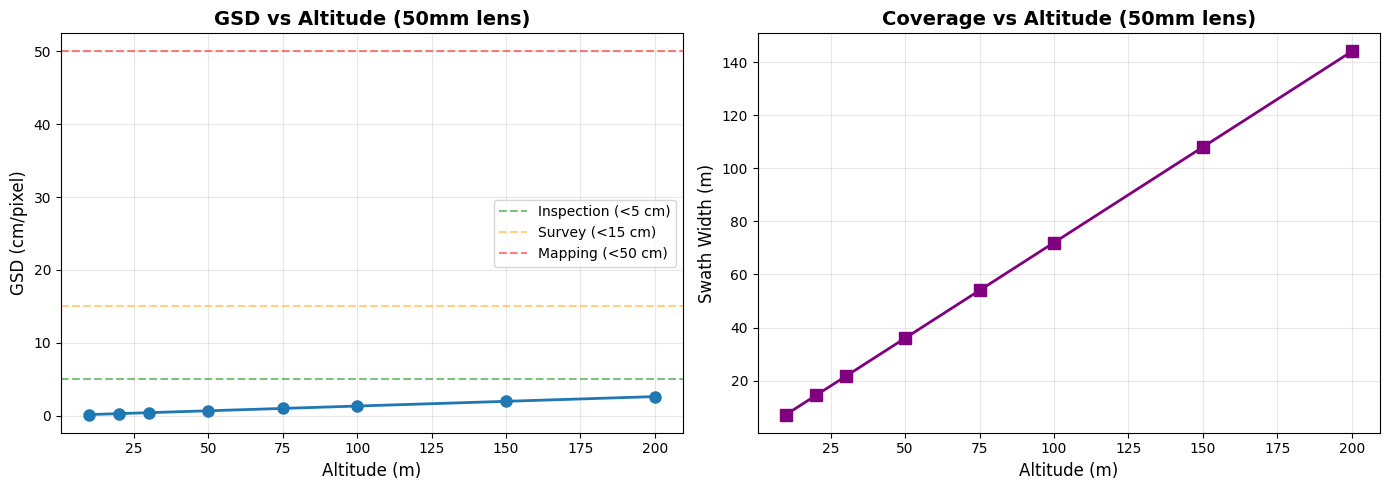


Mission Planning Guidelines:
  Inspection (< 5 cm GSD): Low altitude, high detail
  Survey (< 15 cm GSD): Medium altitude, good balance
  Mapping (< 50 cm GSD): High altitude, wide coverage


In [6]:
# Create altitude range
altitudes = np.array([10, 20, 30, 50, 75, 100, 150, 200])  # meters
GSDs = (altitudes * p) / f * 100  # cm
swath_widths = (sensor_width_m / f) * altitudes  # meters

# Plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# GSD vs Altitude
axes[0].plot(altitudes, GSDs, "o-", linewidth=2, markersize=8)
axes[0].axhline(5, color="g", linestyle="--", alpha=0.5, label="Inspection (<5 cm)")
axes[0].axhline(15, color="orange", linestyle="--", alpha=0.5, label="Survey (<15 cm)")
axes[0].axhline(50, color="r", linestyle="--", alpha=0.5, label="Mapping (<50 cm)")
axes[0].set_xlabel("Altitude (m)", fontsize=12)
axes[0].set_ylabel("GSD (cm/pixel)", fontsize=12)
axes[0].set_title("GSD vs Altitude (50mm lens)", fontsize=14, fontweight="bold")
axes[0].grid(True, alpha=0.3)
axes[0].legend()

# Swath Width vs Altitude
axes[1].plot(altitudes, swath_widths, "s-", linewidth=2, markersize=8, color="purple")
axes[1].set_xlabel("Altitude (m)", fontsize=12)
axes[1].set_ylabel("Swath Width (m)", fontsize=12)
axes[1].set_title("Coverage vs Altitude (50mm lens)", fontsize=14, fontweight="bold")
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nMission Planning Guidelines:")
print("  Inspection (< 5 cm GSD): Low altitude, high detail")
print("  Survey (< 15 cm GSD): Medium altitude, good balance")
print("  Mapping (< 50 cm GSD): High altitude, wide coverage")

## 6. Create Test Scene with Checkerboard

We'll use a checkerboard test target - a canonical pattern for validating aerial imaging systems.

**Important**: The target includes proper margins (25% on each side) for correct optical simulation.

In [7]:
# Create checkerboard test target
# Important: Target resolution must match the instrument's grid size
resolution = scenario.n_pixels  # Match instrument grid size (default 1024)
field_size = swath_width  # Use computed swath width
square_size = 0.10  # 10 cm squares

target = create_checkerboard_target(
    field_size=field_size,
    square_size=square_size,
    resolution=resolution,
    margin_ratio=0.25,  # 25% margin for proper optical simulation
)

# Generate target pattern
scene = target.generate()

print("\nCheckerboard Target Properties:")
print(f"  Field of view: {field_size:.1f} m × {field_size:.1f} m")
print(f"  Square size: {square_size * 100:.0f} cm × {square_size * 100:.0f} cm")
print(f"  Number of squares: {target.checker_config.n_squares} × {target.checker_config.n_squares}")
print(f"  Resolution: {resolution} × {resolution} pixels")
print(f"  Pixel size: {target.config.pixel_size * 100:.2f} cm")
print(f"  Active region: {target.config.active_size} × {target.config.active_size} pixels")
print(f"  Pixels per square: {target.gsd_samples_per_square:.1f}")


Checkerboard Target Properties:
  Field of view: 36.0 m × 36.0 m
  Square size: 10 cm × 10 cm
  Number of squares: 180 × 180
  Resolution: 1024 × 1024 pixels
  Pixel size: 3.52 cm
  Active region: 512 × 512 pixels
  Pixels per square: 2.8


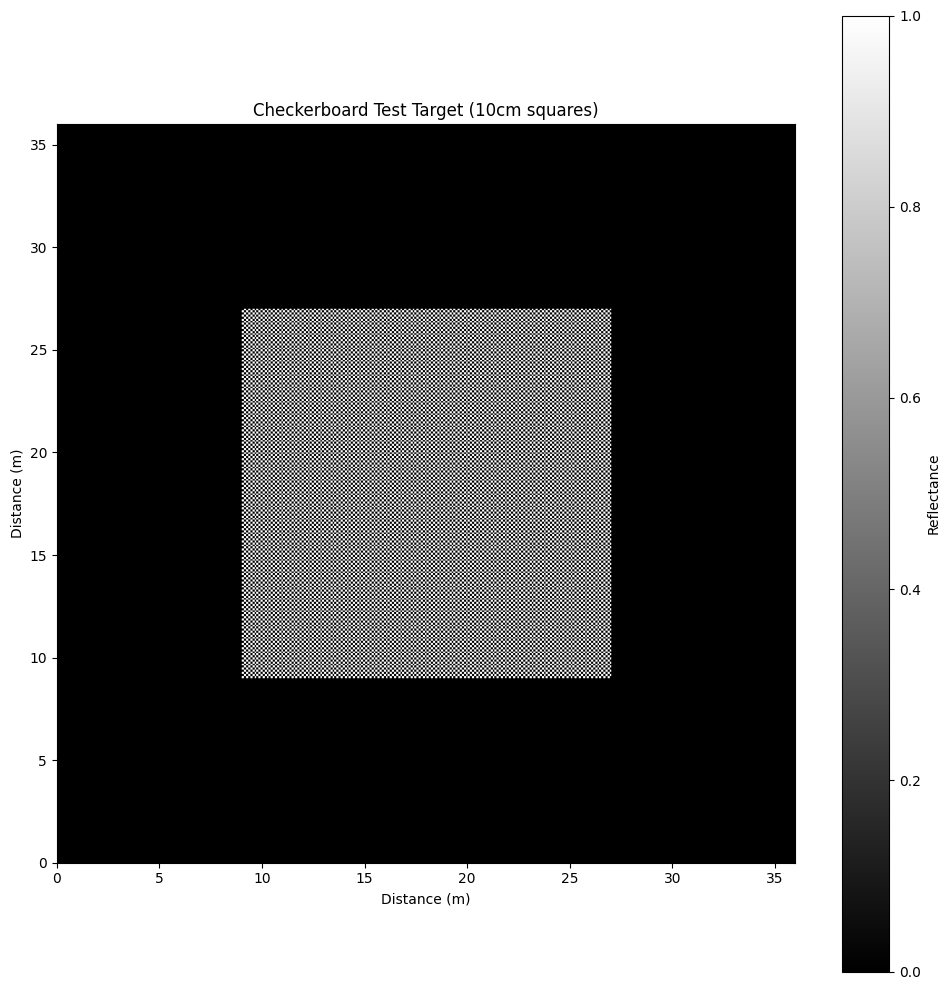

In [8]:
# Visualize scene
plt.figure(figsize=(10, 10))
extent = [0, field_size, 0, field_size]
plt.imshow(scene.cpu().numpy(), cmap="gray", extent=extent, origin="lower")
plt.title(f"Checkerboard Test Target ({square_size * 100:.0f}cm squares)")
plt.xlabel("Distance (m)")
plt.ylabel("Distance (m)")
plt.colorbar(label="Reflectance")
plt.tight_layout()
plt.show()

## 7. Simulate Drone Camera Measurement

Now we'll use the drone camera to capture the scene and see how GSD affects the measurement.

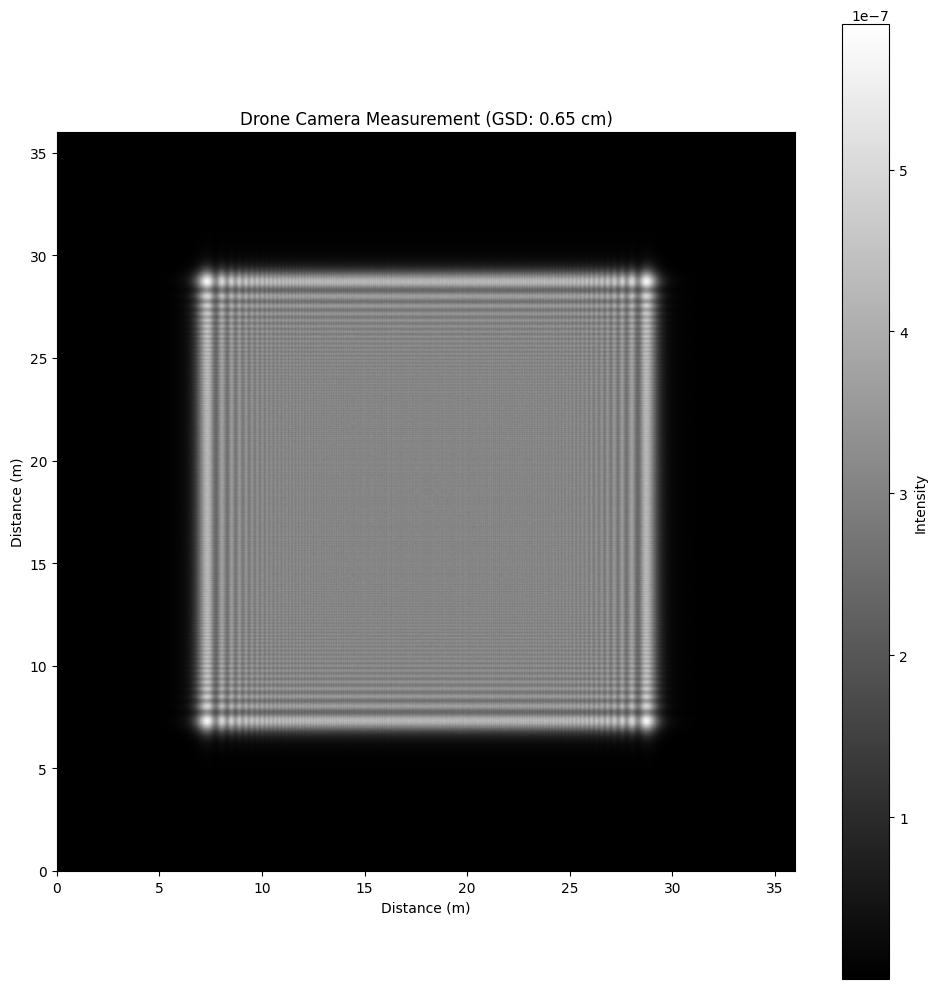


Measurement Statistics:
  Resolution: 1024 × 1024 pixels
  GSD: 0.65 cm/pixel
  Coverage: 36.0 m × 36.0 m


In [9]:
# Simulate measurement
# Input needs batch and channel dimensions: (B, C, H, W)
input_field = scene.unsqueeze(0).unsqueeze(0)

with torch.no_grad():
    measurement = camera.forward(input_field)

# Remove batch and channel dimensions
measurement_2d = measurement.squeeze().cpu().numpy()

# Visualize measurement
plt.figure(figsize=(10, 10))
plt.imshow(measurement_2d, cmap="gray", extent=extent, origin="lower")
plt.title(f"Drone Camera Measurement (GSD: {GSD * 100:.2f} cm)")
plt.xlabel("Distance (m)")
plt.ylabel("Distance (m)")
plt.colorbar(label="Intensity")
plt.tight_layout()
plt.show()

print("\nMeasurement Statistics:")
print(f"  Resolution: {measurement_2d.shape[0]} × {measurement_2d.shape[1]} pixels")
print(f"  GSD: {GSD * 100:.2f} cm/pixel")
print(f"  Coverage: {field_size:.1f} m × {field_size:.1f} m")

## 8. Compare Ground Truth vs Measurement

Let's compare the original scene with the drone camera measurement.

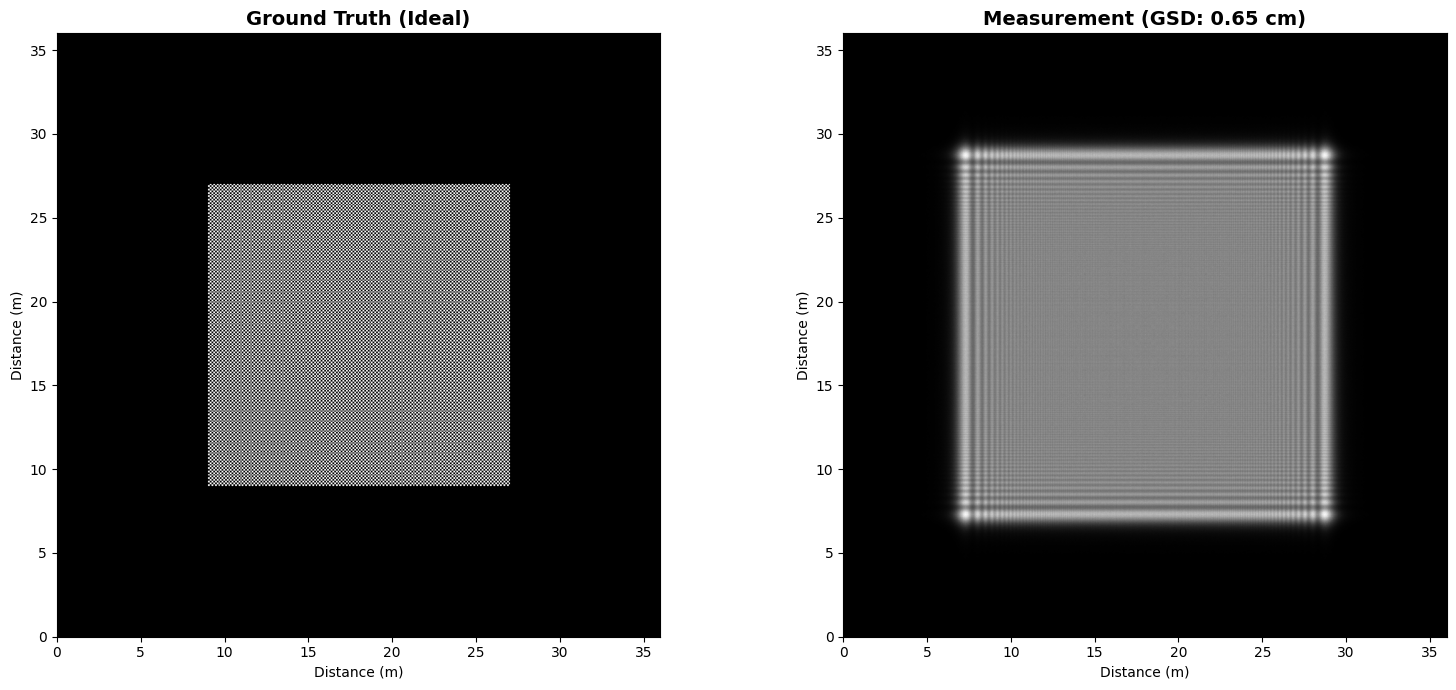


Observations:
  - Each pixel covers 0.65 cm on the ground
  - 10 cm squares are sampled at ~2.8 pixels per square
  - Optical blur from lens aperture affects sharpness
  - Zero-margin borders provide proper optical boundary conditions


In [10]:
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# Ground truth
axes[0].imshow(scene.cpu().numpy(), cmap="gray", extent=extent, origin="lower")
axes[0].set_title("Ground Truth (Ideal)", fontsize=14, fontweight="bold")
axes[0].set_xlabel("Distance (m)")
axes[0].set_ylabel("Distance (m)")

# Measurement
axes[1].imshow(measurement_2d, cmap="gray", extent=extent, origin="lower")
axes[1].set_title(f"Measurement (GSD: {GSD * 100:.2f} cm)", fontsize=14, fontweight="bold")
axes[1].set_xlabel("Distance (m)")
axes[1].set_ylabel("Distance (m)")

plt.tight_layout()
plt.show()

print("\nObservations:")
print(f"  - Each pixel covers {GSD * 100:.2f} cm on the ground")
print(
    f"  - {square_size * 100:.0f} cm squares are sampled at ~{target.gsd_samples_per_square:.1f} pixels per square"
)
print("  - Optical blur from lens aperture affects sharpness")
print("  - Zero-margin borders provide proper optical boundary conditions")

## 9. GSD Footprint Visualization

Let's visualize what a single pixel "sees" on the ground.

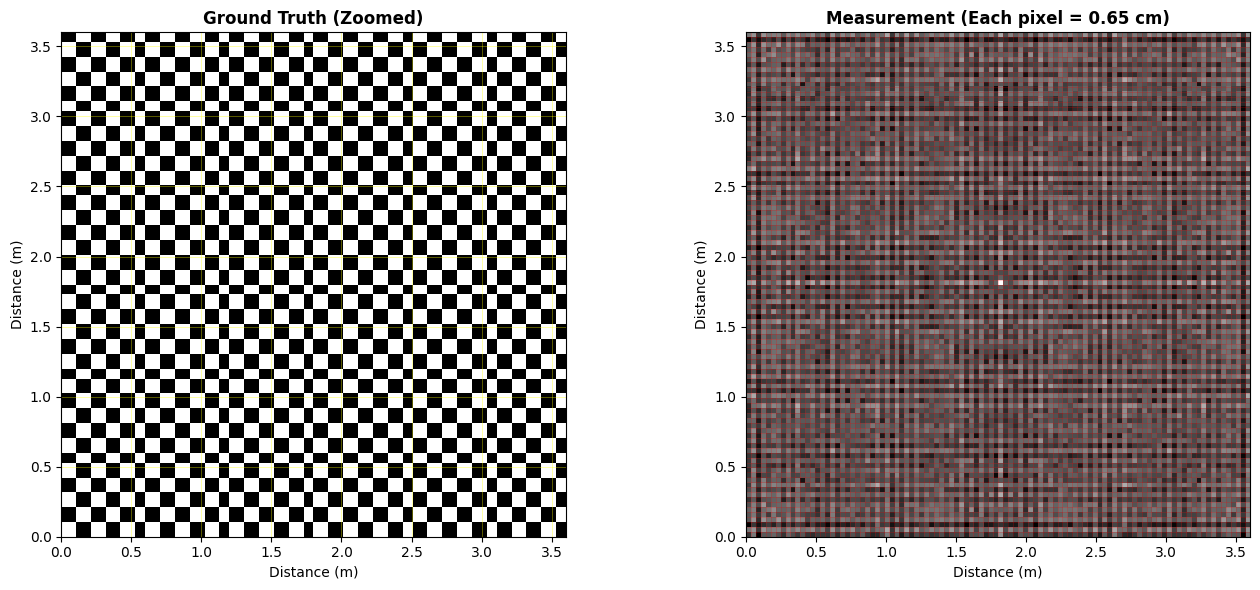


Zoomed view (3.6m × 3.6m):
  Red grid shows individual pixel footprints
  Each grid cell = 0.65 cm × 0.65 cm


In [11]:
# Create zoomed view showing pixel footprints
zoom_factor = 10
center = resolution // 2
zoom_size = resolution // zoom_factor

# Extract zoomed region
zoom_slice = slice(center - zoom_size // 2, center + zoom_size // 2)
scene_zoom = scene[zoom_slice, zoom_slice].cpu().numpy()
measurement_zoom = measurement_2d[zoom_slice, zoom_slice]

# Compute extent in meters
zoom_extent = field_size / zoom_factor

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Ground truth zoom
axes[0].imshow(scene_zoom, cmap="gray", extent=[0, zoom_extent, 0, zoom_extent], origin="lower")
axes[0].set_title("Ground Truth (Zoomed)", fontsize=12, fontweight="bold")
axes[0].set_xlabel("Distance (m)")
axes[0].set_ylabel("Distance (m)")
axes[0].grid(True, alpha=0.5, color="yellow", linewidth=0.5)

# Measurement zoom with pixel grid
im = axes[1].imshow(
    measurement_zoom, cmap="gray", extent=[0, zoom_extent, 0, zoom_extent], origin="lower"
)
axes[1].set_title(f"Measurement (Each pixel = {GSD * 100:.2f} cm)", fontsize=12, fontweight="bold")
axes[1].set_xlabel("Distance (m)")
axes[1].set_ylabel("Distance (m)")

# Draw pixel grid
n_pixels_in_zoom = zoom_size
for i in range(n_pixels_in_zoom + 1):
    pos = i * zoom_extent / n_pixels_in_zoom
    axes[1].axhline(pos, color="red", alpha=0.3, linewidth=0.5)
    axes[1].axvline(pos, color="red", alpha=0.3, linewidth=0.5)

plt.tight_layout()
plt.show()

print(f"\nZoomed view ({zoom_extent:.1f}m × {zoom_extent:.1f}m):")
print("  Red grid shows individual pixel footprints")
print(f"  Each grid cell = {GSD * 100:.2f} cm × {GSD * 100:.2f} cm")

## Summary

In this notebook, we:
1. ✅ Loaded a drone camera preset (`drone_50m_survey`)
2. ✅ Created a camera instrument from the scenario
3. ✅ Computed GSD and swath coverage
4. ✅ Explored GSD vs altitude relationship
5. ✅ Created a checkerboard test target with proper margins
6. ✅ Simulated a drone camera measurement
7. ✅ Visualized pixel footprints

**Key Takeaways**:
- **GSD** determines the level of detail in aerial imagery
- GSD = (altitude × pixel_pitch) / focal_length
- At 50m altitude with 50mm lens: **GSD ≈ 6.5 cm/pixel**
- Higher altitude → larger GSD → less detail but wider coverage
- Mission planning requires balancing detail vs coverage
- Proper margins ensure correct optical simulation

**Mission Guidelines**:
- **Inspection** (< 5 cm GSD): Infrastructure inspection, detailed surveys
- **Survey** (< 15 cm GSD): Agriculture, construction monitoring
- **Mapping** (< 50 cm GSD): Topographic mapping, large area surveys

**Next Steps**:
- Try different altitudes and lenses
- Experiment with motion blur effects
- See [Quickstart 3: Validation Intro](quickstart_03_validation_intro.ipynb) for resolution testing